<a target="_blank" href="https://colab.research.google.com/github/jackma-00/house-price-prediction/blob/main/src/notebooks/2_house_price_weekly_feature_pipeline.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
!pip uninstall scikit-learn -y

Found existing installation: scikit-learn 1.6.0
Uninstalling scikit-learn-1.6.0:
  Successfully uninstalled scikit-learn-1.6.0


In [2]:
!pip install scikit-learn==1.5.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 15.7 MB/s eta 0:00:00


In [3]:
!pip uninstall xgboost -y

Found existing installation: xgboost 2.1.3
Uninstalling xgboost-2.1.3:
  Successfully uninstalled xgboost-2.1.3


In [4]:
!pip install xgboost==2.1.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 4.5 MB/s eta 0:00:00


In [5]:
!pip install hopsworks[python]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 3.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 52.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 73.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.6/258.6 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 87.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 72.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 640.3/640.3 kB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Imports

In [6]:
import os
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
import hopsworks
from hopsworks.hsfs.builtin_transformations import label_encoder
from hopsworks import udf
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

import warnings
warnings.filterwarnings("ignore")

## PostgreSQL Data Fetch

In [7]:
import os
import psycopg2
import pandas as pd
from psycopg2.extras import RealDictCursor
from datetime import datetime, timedelta

def fetch_sales_data(query_date):
    """
    Fetch data from the sale table in the scraping schema.

    Args:
        query_date (str): The date to filter the results by scaping_date.

    Returns:
        list: A list of rows from the table.
    """
    # Load database credentials from environment variables
    DB_NAME = os.getenv("DB_NAME", "integration")
    DB_USER = os.getenv("DB_USER")  # Add username
    DB_PASS = os.getenv("DB_PASS")  # Add password
    DB_HOST = os.getenv("DB_HOST")  # Add host
    DB_PORT = os.getenv("DB_PORT", "5432")

    connection = None
    try:
        # Establish database connection
        connection = psycopg2.connect(
            database=DB_NAME,
            user=DB_USER,
            password=DB_PASS,
            host=DB_HOST,
            port=DB_PORT
        )
        print("Database connected successfully")

        # Create a cursor
        cursor = connection.cursor(cursor_factory=RealDictCursor)

        # Define and execute the query
        query = """
        SELECT s.*, i.*
        from scraping.sale s
        INNER JOIN omi."Interpolated" i
        ON ST_Contains(i.geometry , ST_SetSRID(ST_Point(s.longitude, s.latitude), 4326))
        WHERE s.scraping_date > %s
          AND i.condition_omi = 'scadente'
          AND i.typology_omi = 'Ville e Villini'
        """

        cursor.execute(query, (query_date,))

        # Fetch and return results
        results = cursor.fetchall()
        return pd.DataFrame(results)

    except psycopg2.Error as e:
        print(f"Database error: {e}")
        return []

    finally:
        if connection:
            connection.close()
            print("Database connection closed")

if __name__ == "__main__":
    # Example usage
    query_date = (datetime.now().date() - timedelta(days=7)).strftime("%Y-%m-%d")
    query_date = "2024-12-16"
    results = fetch_sales_data(query_date)

    print("Data fetched successfully")


Database connected successfully
Database connection closed
Data fetched successfully


In [8]:
results

,id,name,createdAt,updatedAt,agencyId,agency,typologyId,typology,latitude,longitude,...,area_territoriale,regione,prezzo_omi_min,prezzo_omi_max,interpolated,zona_omi_type,geometry,ntn,year,semester
0,116852161,"Quadrilocale Lungomare Imperatrice 72, San Sir...",2024-04-03 16:54:11.802607,None,241640.0,AzarovS Real Estate International,14,Appartamento,43.8139,7.7694,...,NORD-OVEST,LIGURIA,1743.936060,2520.590000,with_regression_over_condition,B,0103000020E610000001000000150100008D614ED02617...,None,2023,1
1,116986157,"Quadrilocale via Vincenzo Gioberti 65, Porto V...",2024-04-03 16:54:11.802607,None,241640.0,AzarovS Real Estate International,14,Appartamento,43.8158,7.7776,...,NORD-OVEST,LIGURIA,1890.244284,2730.196072,with_regression_over_condition,B,0103000020E6100000010000002B010000A0C37C790126...,None,2023,1
2,116936883,"Bilocale via Roma, Porto Vecchio, Sanremo",2024-04-03 16:54:11.802607,None,1613.0,Aquamarina Real Estate,14,Appartamento,43.8160,7.7763,...,NORD-OVEST,LIGURIA,1890.244284,2730.196072,with_regression_over_condition,B,0103000020E6100000010000002B010000A0C37C790126...,None,2023,1
3,116825707,"Bilocale via Gaudio, Porto Vecchio, Sanremo",2024-04-03 16:54:11.802607,None,1613.0,Aquamarina Real Estate,14,Appartamento,43.8166,7.7776,...,NORD-OVEST,LIGURIA,1890.244284,2730.196072,with_regression_over_condition,B,0103000020E6100000010000002B010000A0C37C790126...,None,2023,1
4,116657221,"Quadrilocale via Aterno 31/2, Tiburtina, Pescara",2024-04-03 16:54:11.802607,None,32086.0,Spazio Real Estate,14,Appartamento,42.4595,14.2082,...,SUD,ABRUZZO,602.731913,878.675765,with_regression_over_condition,D,0103000020E6100000010000009A0000005AF624B0396F...,None,2023,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60050,116887873,"Quadrilocale ottimo stato, su più livelli, Cen...",2024-04-03 16:54:11.802607,None,220096.0,Silvia Zanardi Real Estate,14,Appartamento,46.5454,12.1351,...,NORD-EST,VENETO,6645.261564,7411.398357,with_regression_over_condition,B,0106000020E61000000600000001030000000100000005...,None,2023,1
60051,116673499,"Quadrilocale corso Orazio Raimondo, Porto Vecc...",2024-04-03 16:54:11.802607,None,189146.0,Borra Immobiliare,14,Appartamento,43.8198,7.7844,...,NORD-OVEST,LIGURIA,1890.244284,2730.196072,with_regression_over_condition,B,0103000020E6100000010000002B010000A0C37C790126...,None,2023,1
60052,116749269,"Trilocale corso Trento Trieste 11, Porto Vecch...",2024-04-03 16:54:11.802607,None,241640.0,AzarovS Real Estate International,14,Appartamento,43.8172,7.7803,...,NORD-OVEST,LIGURIA,1890.244284,2730.196072,with_regression_over_condition,B,0103000020E6100000010000002B010000A0C37C790126...,None,2023,1
60053,116882009,"Bilocale buono stato, Centro, Gambassi Terme",2024-04-03 16:54:11.802607,None,153849.0,Boccaccio Case,14,Appartamento,43.5320,10.9498,...,CENTRO,TOSCANA,829.509660,1228.019220,with_regression_over_condition,B,0103000020E61000000100000028010000D40FEA2285EA...,None,2023,1


In [9]:
last_date = results['scraping_date'].max()

print("The last date is:", last_date)

The last date is: 2024-12-23


In [10]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60055 entries, 0 to 60054
Data columns (total 65 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id                   60055 non-null  int64         
 1   name                 60055 non-null  object        
 2   createdAt            60055 non-null  datetime64[ns]
 3   updatedAt            0 non-null      object        
 4   agencyId             57744 non-null  float64       
 5   agency               57744 non-null  object        
 6   typologyId           60055 non-null  int64         
 7   typology             60055 non-null  object        
 8   latitude             60055 non-null  float64       
 9   longitude            60055 non-null  float64       
 10  region               60055 non-null  object        
 11  province             60055 non-null  object        
 12  city                 60055 non-null  object        
 13  zona                 44003 non-

## Connect to Hopsworks Feature Store

In [11]:
# If you haven't set the env variable 'HOPSWORKS_API_KEY', then uncomment the next line and enter your API key
os.environ["HOPSWORKS_API_KEY"] = ""
proj = hopsworks.login()
fs = proj.get_feature_store()
mr = proj.get_model_registry()
ms = proj.get_model_serving()


Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1158295


## Save new data to feature store

In [16]:
def preprocess_properties_data(properties_df):
    """
    Preprocess the properties DataFrame.

    Args:
        properties_df (pd.DataFrame): Raw properties data.

    Returns:
        pd.DataFrame: Preprocessed properties DataFrame.
    """

    # Convert column names to lowercase
    properties_df.columns = properties_df.columns.str.lower()

    # Rename column 'comuneid' to 'codcom'
    properties_df.rename(columns={"comuneid": "codcom"}, inplace=True)

    # Select relevant columns
    selected_columns = [
        "id",
        "scraping_date",
        "agencyid",
        "bedroomsnumber",
        "buildingyear",
        "codcom",
        "gsm",
        "surface",
        "latitude",
        "longitude",
        "isluxury",
        "isnew",
        "on_the_market",
        "zeroenergybuilding",
        "airconditioning",
        "bathrooms",
        "city",
        "condition",
        "energyclass",
        "ga4heating",
        "garage",
        "heatingtype",
        "pricerange",
        "rooms",
        "id_zona_omi",
        "price",
    ]
    properties_df = properties_df[selected_columns]

    # Drop missing values
    properties_df.dropna(inplace=True)

    # Convert boolean features to integers
    boolean_columns = ["isluxury", "isnew", "on_the_market", "zeroenergybuilding"]
    properties_df[boolean_columns] = properties_df[boolean_columns].astype(int)

    # Convert codcom from bigint to double
    properties_df["codcom"] = properties_df["codcom"].astype(float)

    # Parse and sort by scraping_date
    properties_df["scraping_date"] = pd.to_datetime(properties_df["scraping_date"])
    properties_df.sort_values(by="scraping_date", inplace=True)

    return properties_df

new_data = preprocess_properties_data(results)

In [17]:
new_data

,id,scraping_date,agencyid,bedroomsnumber,buildingyear,codcom,gsm,surface,latitude,longitude,...,city,condition,energyclass,ga4heating,garage,heatingtype,pricerange,rooms,id_zona_omi,price
3692,102173164,2024-12-23,47110.0,3.0,2023.0,7668.0,633.0,160,45.7814,9.02120,...,Villa Guardia,Nuovo / In costruzione,A+,Autonomo,"1 in box privato/box in garage, 1 in parcheggi...","autonomo, a pavimento, alimentato a metano",300.001 - 500.000 &euro;,4,L956-B1,395000.0
56462,109153053,2024-12-23,146346.0,4.0,2000.0,6820.0,324.0,203,42.5217,12.16900,...,Viterbo,Ottimo / Ristrutturato,G,Autonomo,"1 in box privato/box in garage, 2 in parcheggi...","autonomo, a radiatori, alimentato a fotovoltaico",200.001 - 300.000 &euro;,5+,M082-E3,215000.0
55952,110028309,2024-12-23,331.0,4.0,1974.0,12137.0,288.0,324,45.4327,11.88820,...,Padova,Buono / Abitabile,F,Autonomo,"2 in box privato/box in garage, 2 in parcheggi...","autonomo, a radiatori, alimentato a metano",300.001 - 500.000 &euro;,5+,G224-D7,465000.0
55772,104816145,2024-12-23,179055.0,2.0,2023.0,12319.0,524.0,96,45.6529,12.22640,...,Treviso,Nuovo / In costruzione,A,Autonomo,1 in box privato/box in garage,"autonomo, a pavimento",200.001 - 300.000 &euro;,3,L407-D2,257000.0
55287,103067304,2024-12-23,10864.0,3.0,2023.0,7668.0,592.0,160,45.7664,9.02620,...,Villa Guardia,Nuovo / In costruzione,A4,Autonomo,"2 in box privato/box in garage, 2 in parcheggi...","autonomo, a pavimento, alimentato a pompa di c...",300.001 - 500.000 &euro;,5,L956-D1,470000.0
54293,112129605,2024-12-23,117473.0,3.0,2024.0,7668.0,292.0,156,45.7739,9.02100,...,Villa Guardia,Nuovo / In costruzione,A4,Autonomo,"2 in box privato/box in garage, 1 in parcheggi...",autonomo,300.001 - 500.000 &euro;,4,L956-B1,385000.0
54047,111955587,2024-12-23,211046.0,1.0,2023.0,12319.0,213.0,60,45.6591,12.22750,...,Treviso,Ottimo / Ristrutturato,B,Autonomo,2 in parcheggio/garage comune,autonomo,200.001 - 300.000 &euro;,2,L407-D2,220000.0
54015,111166773,2024-12-23,126274.0,4.0,1980.0,5796.0,243.0,212,40.2458,15.27210,...,Moio della Civitella,Buono / Abitabile,Sconosciuta,Autonomo,1 in parcheggio/garage comune,autonomo,200.001 - 300.000 &euro;,5+,F278-B1,220000.0
52089,109344719,2024-12-23,24573.0,3.0,2025.0,7668.0,317.0,123,45.7713,9.01020,...,Villa Guardia,Nuovo / In costruzione,A2,Centralizzato,"2 in box privato/box in garage, 1 in parcheggi...","centralizzato, a pavimento, alimentato a pompa...",300.001 - 500.000 &euro;,4,L956-D1,335000.0
43128,84959102,2024-12-23,62629.0,2.0,1990.0,10285.0,1442.0,70,41.4688,15.54030,...,Foggia,Buono / Abitabile,F,Autonomo,2 in box privato/box in garage,"autonomo, a radiatori, alimentato a gas",fino a 100.000 &euro;,3,D643-C4,89000.0


In [18]:
def save_to_feature_store(fs, properties_df):
    """
    Save the properties DataFrame to the feature store.

    Args:
        fs: Feature store object.
        properties_df (pd.DataFrame): Preprocessed properties data.
    """
    properties_fg = fs.get_or_create_feature_group(
        name="properties",
        version=4,
        description="Property Features and Corresponding Prices",
        online_enabled=True,
        primary_key=["id"],
        event_time="scraping_date",
    )
    properties_fg.insert(
        properties_df, wait=True
    )  # Wait for data materialization to finish before returning


save_to_feature_store(fs, new_data)

Uploading Dataframe: 100.00% |██████████| Rows 27/27 | Elapsed Time: 00:00 | Remaining Time: 00:00


Launching job: properties_4_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1158295/jobs/named/properties_4_offline_fg_materialization/executions


## Get feature view and latest data

In [19]:
feature_view = fs.get_feature_view("house_price_fv", 5)

In [20]:
TEST_SIZE = 0.2

X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_size=TEST_SIZE,
    description='house price training dataset',
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.32s) 


## Retrain the model

In [ ]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "house_price_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

In [ ]:
param_distributions = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [4, 6, 8, 10],
    'min_child_weight': [1, 5, 10],
    'gamma': [0, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_lambda': [0, 1, 5],
    'reg_alpha': [0, 1, 5]
}

random_search = RandomizedSearchCV(
    estimator=XGBRegressor(),
    param_distributions=param_distributions,
    n_iter=50,  # Number of parameter settings sampled
    scoring='r2',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
best_model = random_search.best_estimator_

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'subsample': 1.0, 'reg_lambda': 5, 'reg_alpha': 1, 'n_estimators': 300, 'min_child_weight': 10, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}


In [ ]:
# Predicting target values on the test set
y_pred = best_model.predict(X_test)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)

MSE: 26982919338.538036
R squared: 0.8276609982020513


In [ ]:
df = y_test
df['predicted_price'] = y_pred
df = df.sort_values(by="price").reset_index(drop=True)
df.head(5)

,price,predicted_price
0,35000.0,72810.023438
1,47000.0,63266.773438
2,55000.0,76646.437500
3,55000.0,56229.046875
4,56000.0,97052.515625


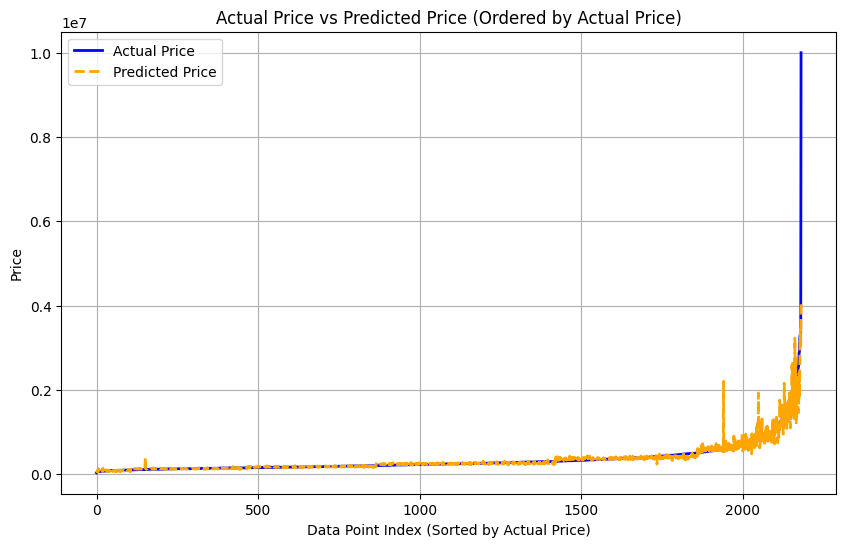

In [ ]:
# Plot
plt.figure(figsize=(10, 6))  # Set figure size
plt.plot(df.index, df["price"], label="Actual Price", color='blue', linewidth=2)
plt.plot(df.index, df["predicted_price"], label="Predicted Price", color='orange', linestyle='--', linewidth=2)

# Labels, Title, and Legend
plt.xlabel("Data Point Index (Sorted by Actual Price)")
plt.ylabel("Price")
plt.title("Actual Price vs Predicted Price (Ordered by Actual Price)")
plt.legend()

# Grid
plt.grid(True)

# Save the plot to the desired file path
os.makedirs(images_dir, exist_ok=True)  # Create the directory if it doesn't exist
file_path = images_dir + "/price_hindcast.png"
plt.savefig(file_path, format='png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

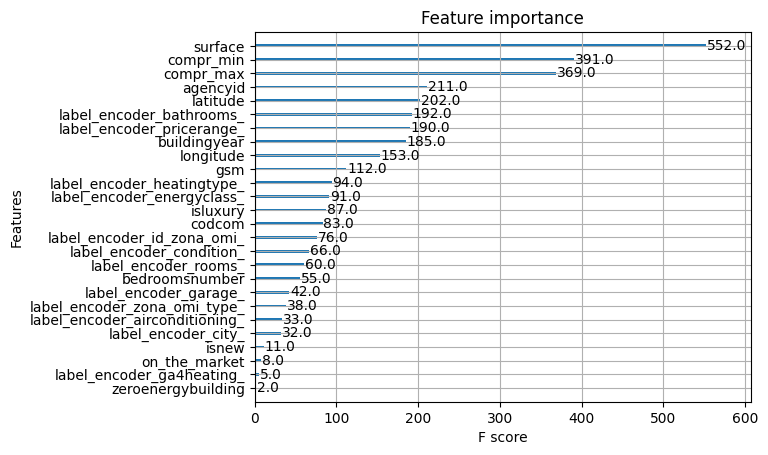

In [ ]:
plot_importance(best_model, importance_type='weight')
feature_importance_path = images_dir + "/feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()

## Update Model Registry

In [ ]:
# Creating input and output schemas using the 'Schema' class for features (X) and target variable (y)
input_schema = Schema(X_train)
output_schema = Schema(y_train)

# Creating a model schema using 'ModelSchema' with the input and output schemas
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

# Converting the model schema to a dictionary representation
schema_dict = model_schema.to_dict()

In [ ]:
# Saving the XGBoost regressor object as a json file in the model directory
best_model.save_model(model_dir + "/model.json")

In [ ]:
res_dict = {
        "MSE": str(mse),
        "R squared": str(r2),
    }

In [ ]:
hp_model = mr.python.create_model(
    name="house_price_xgboost_model",
    metrics=res_dict,
    feature_view=feature_view,                    # Add a feature view to the model
    model_schema=model_schema,
    input_example=X_test.sample().values,
    description="Italian house price predictor",
)

# Saving the model artifacts to the 'house_price_model' directory in the model registry
hp_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/465401 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/145436 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/61439 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/173 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/2379 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1158295/models/house_price_xgboost_model/18


Model(name: 'house_price_xgboost_model', version: 18)

## Create new deployment

In [ ]:
retrieved_models = mr.get_models("house_price_xgboost_model")
retrieved_models

[Model(name: 'house_price_xgboost_model', version: 13),
 Model(name: 'house_price_xgboost_model', version: 18),
 Model(name: 'house_price_xgboost_model', version: 8),
 Model(name: 'house_price_xgboost_model', version: 14),
 Model(name: 'house_price_xgboost_model', version: 15),
 Model(name: 'house_price_xgboost_model', version: 16),
 Model(name: 'house_price_xgboost_model', version: 1)]

In [ ]:
# Get latest version
sorted_models = sorted(retrieved_models, key=lambda x: x.version)
latest_model = sorted_models[-1]
latest_model

Model(name: 'house_price_xgboost_model', version: 18)

In [ ]:
deployment = ms.get_deployment("house")

In [ ]:
# Delete the old deployment
deployment.delete(force=True)

Deployment deleted successfully


In [ ]:
predictor_script_path = os.path.join("/Projects", proj.name, "Models", "predict_house_price.py")
predictor_script_path

'/Projects/id2223_group_17_labs/Models/predict_house_price.py'

In [ ]:
# Deploy the new model
deployment = latest_model.deploy(
    name="house",                 # Specify the deployment name
    script_file=predictor_script_path,  # Provide the path to the predictor script
)

Deployment created, explore it at https://c.app.hopsworks.ai:443/p/1158295/deployments/352270
Before making predictions, start the deployment by using `.start()`


In [ ]:
# Start the deployment and wait for it to be running, with a maximum waiting time of 180 seconds
deployment.start(await_running=180)

  0%|          | 0/5 [00:00<?, ?it/s]

Start making predictions by using `.predict()`
